In [5]:
# !wget --header="Host: storage.googleapis.com" --header="User-Agent: Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.86 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: https://www.kaggle.com/" "https://storage.googleapis.com/kaggle-datasets/87153/200743/cell-images-for-detecting-malaria.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1554030372&Signature=TebHa3x60W5Fh8Eh09X7a6q6eHQgfJI15kSz1jzQ%2FbPKOJ8K%2BpLtM%2BfEsXbu%2BpW0ByIFgn49BV844ketChZozyziW8tByVJ2f3MXDxP5HAQH1b8z226UCeLsRQZR7eWKgH25A24D1W5HopBwhRH0sC7QiXksNG6fMeQrI0gQp2MsPmJXB1m4yQlRx%2BCc2o2VajVK2wuMD%2FjS%2BSrKcDH8NxUHfRMJJDIh4loV3mqe6Cn2BSRfUwl4G4EOpoqbv%2BxMNXb0FgOPv7yVqoQkYHfYSHa8Q34RY7Nndlkow53wpofVkjB9BxgyZZpMekplst63vHH84fzaZcbWUANn5s92Rg%3D%3D" -O "cell-images-for-detecting-malaria.zip" -c


In [4]:
# !unzip cell-images-for-detecting-malaria.zip

In [3]:
!ls cell_images/

Parasitized  Uninfected


In [18]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

import torch
from torch import nn, optim
from torchvision import transforms, datasets, models
from torch.utils.data.sampler import SubsetRandomSampler

In [17]:
from my_ml_lib import MetricTools, PlotTools

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [10]:
data_transforms = transforms.Compose([
    transforms.RandomResizedCrop(64),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [11]:
data_dir = 'cell_images/'
data = datasets.ImageFolder(data_dir, transform=data_transforms)

In [12]:
valid_pct = 0.2
test_pct = 0.1

In [13]:
data_len = len(data)
data_indices = list(range(data_len))
np.random.shuffle(data_indices)

valid_split = int(np.floor((valid_pct) * data_len))
test_split = int(np.floor((valid_pct + test_pct) * data_len))

valid_idx, test_idx, train_idx = data_indices[:valid_split], data_indices[valid_split:test_split], data_indices[test_split:]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)

dataloaders = {
    'train': torch.utils.data.DataLoader(data, batch_size=64, sampler=train_sampler),
    'valid': torch.utils.data.DataLoader(data, batch_size=32, sampler=valid_sampler),
    'test': torch.utils.data.DataLoader(data, batch_size=20, sampler=test_sampler)
}

print(len(valid_idx), len(test_idx), len(train_idx))

5511 2756 19291


In [14]:
invTrans = transforms.Compose([ transforms.Normalize([ 0., 0., 0. ],[ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize([ -0.485, -0.456, -0.406 ],[ 1., 1., 1. ]),
                               ])

def imshow(img):
    img = invTrans(img)
    img = img.numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)))

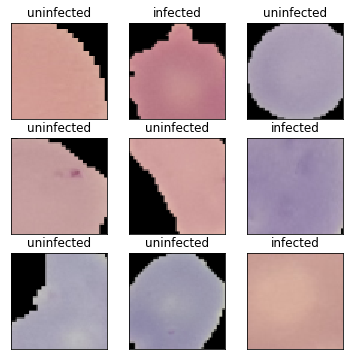

In [19]:
classes=['infected','uninfected']

dataiter = iter(dataloaders['train'])
images, labels = dataiter.next()

fig = plt.figure(figsize=(6, 6))
# display 20 images
for idx in np.arange(9):
    ax = fig.add_subplot(3, 3, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])
plt.savefig('plots/data_vis.png')

In [41]:
# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Linear(8*8*64, 500),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(500, 100),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(100, 2)
        )
    
    def forward(self, x):
        out = self.layer1(x)
        out = out.view(out.shape[0], -1)
        out = self.fc(out)
        return out


model_scratch = Net()
model_scratch.to(device)

Net(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=4096, out_features=500, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2)
    (3): Linear(in_features=500, out_features=100, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2)
    (6): Linear(in_features=100, 

In [42]:
criterion_scratch = nn.CrossEntropyLoss()

# optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.001, momentum=0.9)
optimizer_scratch = optim.Adam(model_scratch.parameters(), lr=0.001)

In [43]:
def train(n_epochs, loaders, model, optimizer, criterion, device, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    train_losses = []
    val_losses = []
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU or CPU
            data, target = data.to(device), target.to(device)
            
            ## find the loss and update the model parameters accordingly
            ## record the average training loss as follows
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            
            loss.backward()
            optimizer.step()
            
            train_loss += ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU or CPU
            data, target = data.to(device), target.to(device)
            
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            
            valid_loss += ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        train_losses.append(train_loss)
        val_losses.append(valid_loss)
        
        if valid_loss < valid_loss_min:
            print('Saving model..')
            valid_loss_min = valid_loss
            torch.save(model.state_dict(), save_path)
    
    # return trained model
    return model, train_losses, val_losses

In [44]:
# train the model
model_scratch, train_losses, val_losses = train(20, dataloaders, model_scratch, optimizer_scratch, 
                                                criterion_scratch, device, 'models/model_scratch-img64.pt')

Epoch: 1 	Training Loss: 0.449945 	Validation Loss: 0.360567
Saving model..
Epoch: 2 	Training Loss: 0.357576 	Validation Loss: 0.339078
Saving model..
Epoch: 3 	Training Loss: 0.332712 	Validation Loss: 0.341607
Epoch: 4 	Training Loss: 0.328441 	Validation Loss: 0.318959
Saving model..
Epoch: 5 	Training Loss: 0.318843 	Validation Loss: 0.338371
Epoch: 6 	Training Loss: 0.311118 	Validation Loss: 0.307686
Saving model..
Epoch: 7 	Training Loss: 0.304950 	Validation Loss: 0.301697
Saving model..
Epoch: 8 	Training Loss: 0.309147 	Validation Loss: 0.304863
Epoch: 9 	Training Loss: 0.307798 	Validation Loss: 0.302695
Epoch: 10 	Training Loss: 0.299762 	Validation Loss: 0.323098
Epoch: 11 	Training Loss: 0.295816 	Validation Loss: 0.306051
Epoch: 12 	Training Loss: 0.293260 	Validation Loss: 0.285249
Saving model..
Epoch: 13 	Training Loss: 0.292022 	Validation Loss: 0.284853
Saving model..
Epoch: 14 	Training Loss: 0.289929 	Validation Loss: 0.308076
Epoch: 15 	Training Loss: 0.294150 	

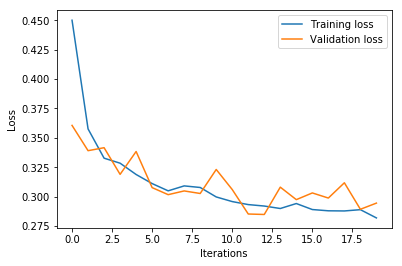

In [57]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
_ = plt.ylim()
# plt.title('Training Validation Loss with CNN from scratch')
plt.savefig('plots/Training Validation Loss with CNN from scratch.png')
plt.show()

In [46]:
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('models/model_scratch-img64.pt'))

In [47]:
def test(loaders, model, criterion, device):
    sigmoid = lambda x: 1 / (1 + np.exp(-x))
    
    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.
    y = None
    y_hat = None
    
    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU or CPU
        data, target = data.to(device), target.to(device)
        
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        
        if y is None:
            y = target.cpu().numpy()
            y_hat = pred.data.cpu().view_as(target).numpy()
        else:
            y = np.append(y, target.cpu().numpy())
            y_hat = np.append(y_hat, pred.data.cpu().view_as(target).numpy())
            
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))
    
    return y, y_hat

In [48]:
# call test function    
y, y_hat = test(dataloaders, model_scratch, criterion_scratch, device)

Test Loss: 0.278942


Test Accuracy: 88% (2429/2756)


In [49]:
cm = MetricTools.confusion_matrix(y, y_hat, nclasses=2)

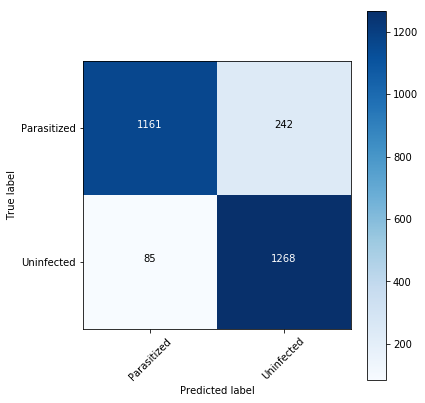

In [58]:
PlotTools.confusion_matrix(cm, ['Parasitized', 'Uninfected'], title='',
                           filename='Confusion Matrix with CNN from scratch', figsize=(6,6), path='plots/')

In [51]:
prec, rec = MetricTools.prec_recall(y, y_hat, 2)
f1 = 1 /(0.5 * (1/prec + 1/rec))

In [60]:
np.around([prec, rec, f1], 3), 

(array([0.932, 0.828, 0.877]),)